In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec 21 01:55:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    50W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
### Cloning Github Repository 
!git clone https://github.com/yhenon/pytorch-retinanet.git

Cloning into 'pytorch-retinanet'...
remote: Enumerating objects: 232, done.
remote: Total 232 (delta 0), reused 0 (delta 0), pack-reused 232
Receiving objects: 100% (232/232), 1.02 MiB | 6.75 MiB/s, done.
Resolving deltas: 100% (119/119), done.


In [5]:
### Copying RetinaNet Folder to root dir so we can import it easily
!cp -r /content/pytorch-retinanet/retinanet ./

In [6]:
! pip install pycocotools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import os
import re
import cv2
import time
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from PIL import Image, ImageDraw


import torch
import torch.optim as optim
import torchvision.transforms as T
from torchvision.utils import make_grid 
from torch.utils.data import DataLoader, Dataset

from retinanet import model
from retinanet.dataloader import collater, Resizer, Augmenter, Normalizer, UnNormalizer, CSVDataset
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [8]:
!pip install kaggle

from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jabullae","key":"9615fe6e84855ac0d22aa288ab5d10bd"}'}

In [9]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
! kaggle datasets download -d kneroma/tacotrashdataset

100% 2.78G/2.79G [00:31<00:00, 89.6MB/s]
100% 2.79G/2.79G [00:31<00:00, 96.0MB/s]


In [11]:
! unzip tacotrashdataset.zip

Archive:  tacotrashdataset.zip
  inflating: best-checkpoint-003epoch.bin  
  inflating: data/annotations.json   
  inflating: data/batch_1/000000.jpg  
  inflating: data/batch_1/000001.jpg  
  inflating: data/batch_1/000003.jpg  
  inflating: data/batch_1/000004.jpg  
  inflating: data/batch_1/000005.jpg  
  inflating: data/batch_1/000006.jpg  
  inflating: data/batch_1/000007.jpg  
  inflating: data/batch_1/000008.jpg  
  inflating: data/batch_1/000010.jpg  
  inflating: data/batch_1/000011.jpg  
  inflating: data/batch_1/000012.jpg  
  inflating: data/batch_1/000013.jpg  
  inflating: data/batch_1/000014.jpg  
  inflating: data/batch_1/000015.jpg  
  inflating: data/batch_1/000016.jpg  
  inflating: data/batch_1/000017.jpg  
  inflating: data/batch_1/000019.jpg  
  inflating: data/batch_1/000021.jpg  
  inflating: data/batch_1/000022.jpg  
  inflating: data/batch_1/000023.jpg  
  inflating: data/batch_1/000024.jpg  
  inflating: data/batch_1/000025.jpg  
  inflating: data/batch_1/000

In [12]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

# %pip install torch==1.9.0 torchvision==0.10.0 torchaudio==0.9.0

import torch
from yolov5 import utils
display = utils.notebook_init()  # checks
print (torch.__version__)

YOLOv5 🚀 v7.0-46-g96a71b1 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (A100-SXM4-40GB, 40536MiB)


Setup complete ✅ (12 CPUs, 83.5 GB RAM, 28.6/166.8 GB disk)
1.13.0+cu116


In [14]:
# Get data from annotations
path_to_anno = '/content/data/annotations.json'

with open(path_to_anno) as f:
  data = json.load(f)

print(type(data))
print()

# required classes for my problem statement
classes_req = ['Bottle', 'Can', 'Cup', 'Paper']
classes = {}
classes_id = {}

for i in data['categories']:
  if(i['supercategory'] in classes_req):
    classes[i['id']] = i['name']

print(classes)
print("Number of classes: ", len(classes))
print()

#Get image path and data 
images_data = {}

for i in data['images']:
  temp = {
      'file_n': '/content/data/'+i['file_name'],
      'width': i['width'],
      'height': i['height'],
  }
  images_data[i['id']] = temp
print("Image data gathered")
print()

#Check if bounding box is valid
def is_valid(x_min, y_min, x_max, y_max, width, height):
    return (x_min in range(0, width)) and (x_max in range(0, width)) and (y_min in range(0, height)) and (y_max in range(0, width))


filter_class = {
    'Other plastic bottle': "Bottle", 
    'Clear plastic bottle': "Bottle",  
    'Glass bottle': 'Bottle',
    'Food Can': 'Can', 
    'Aerosol': 'Can', 
    'Drink can': 'Can', 
    'Paper cup': 'Cup', 
    'Disposable plastic cup': 'Cup', 
    'Foam cup': 'Cup', 
    'Glass cup': 'Cup', 
    'Other plastic cup': 'Cup', 
    'Magazine paper': 'Paper', 
    'Tissues': 'Paper', 
    'Wrapping paper': 'Paper', 
    'Normal paper': 'Paper'}

    
# Group images with their data
images_with_anno = []
not_valid=0
for i in data['annotations']:
  if(i['category_id'] in classes.keys()):
    img_d = images_data[i['image_id']]
    x_min= int(i['bbox'][0])
    y_min= int(i['bbox'][1])
    x_max= int(i['bbox'][0]+i['bbox'][2])
    y_max= int(i['bbox'][1]+i['bbox'][3])
    valid = is_valid(x_min, y_min, x_max, y_max, img_d['width'], img_d['height'])
    temp = {
        'image_name': img_d['file_n'],
        'x_min': int(i['bbox'][0]),
        'y_min': int(i['bbox'][1]),
        'x_max': int(i['bbox'][0]+i['bbox'][2]),
        'y_max': int(i['bbox'][1]+i['bbox'][3]),
        'class_name': filter_class[classes[i['category_id']]],
    }
    if(valid):
        images_with_anno.append(temp)
    else:
        not_valid+=1

print("Complete dict generated", "\nFound not valid: ", not_valid)
print()


<class 'dict'>

{4: 'Other plastic bottle', 5: 'Clear plastic bottle', 6: 'Glass bottle', 10: 'Food Can', 11: 'Aerosol', 12: 'Drink can', 20: 'Paper cup', 21: 'Disposable plastic cup', 22: 'Foam cup', 23: 'Glass cup', 24: 'Other plastic cup', 30: 'Magazine paper', 31: 'Tissues', 32: 'Wrapping paper', 33: 'Normal paper'}
Number of classes:  15

Image data gathered

Complete dict generated 
Found not valid:  184



In [23]:
images_with_anno

[{'image_name': '/content/data/batch_1/000006.jpg',
  'x_min': 517,
  'y_min': 127,
  'x_max': 964,
  'y_max': 1449,
  'class_name': 'Bottle'},
 {'image_name': '/content/data/batch_1/000010.jpg',
  'x_min': 632,
  'y_min': 987,
  'x_max': 1132,
  'y_max': 1361,
  'class_name': 'Bottle'},
 {'image_name': '/content/data/batch_1/000019.jpg',
  'x_min': 209,
  'y_min': 920,
  'x_max': 663,
  'y_max': 1482,
  'class_name': 'Bottle'},
 {'image_name': '/content/data/batch_1/000019.jpg',
  'x_min': 1212,
  'y_min': 822,
  'x_max': 1391,
  'y_max': 1268,
  'class_name': 'Bottle'},
 {'image_name': '/content/data/batch_1/000019.jpg',
  'x_min': 589,
  'y_min': 548,
  'x_max': 930,
  'y_max': 953,
  'class_name': 'Can'},
 {'image_name': '/content/data/batch_1/000026.jpg',
  'x_min': 556,
  'y_min': 944,
  'x_max': 1046,
  'y_max': 1280,
  'class_name': 'Can'},
 {'image_name': '/content/data/batch_1/000047.jpg',
  'x_min': 1205,
  'y_min': 47,
  'x_max': 1828,
  'y_max': 768,
  'class_name': 'Can'}

In [16]:
df = pd.DataFrame(images_with_anno)

In [17]:
train_df, test_df = train_test_split(df, test_size=0.2)

In [18]:
train_df.to_csv('annotations.csv', index=False, header=None)

In [19]:
test_df.to_csv('test_annotations.csv', index=False, header=None)

In [20]:
with open('classes.csv', 'w') as f:
  for i, (class_name) in enumerate(train_df['class_name'].unique()):
    f.write(f'{class_name},{i}\n')

In [21]:
train_data = CSVDataset('./annotations.csv', './classes.csv', transform = T.Compose([Augmenter(), Normalizer(), Resizer()]))

In [22]:
test_data = CSVDataset('./test_annotations.csv', './classes.csv', transform = T.Compose([Augmenter(), Normalizer(), Resizer()]))

In [29]:
df

,image_name,x_min,y_min,x_max,y_max,class_name
0,/content/data/batch_1/000006.jpg,517,127,964,1449,Bottle
1,/content/data/batch_1/000010.jpg,632,987,1132,1361,Bottle
2,/content/data/batch_1/000019.jpg,209,920,663,1482,Bottle
3,/content/data/batch_1/000019.jpg,1212,822,1391,1268,Bottle
4,/content/data/batch_1/000019.jpg,589,548,930,953,Can
...,...,...,...,...,...,...
863,/content/data/batch_9/000091.jpg,1260,1274,1777,1584,Bottle
864,/content/data/batch_9/000094.jpg,2258,766,2622,1001,Bottle
865,/content/data/batch_9/000094.jpg,1459,1094,1691,1364,Bottle
866,/content/data/batch_9/000097.jpg,354,575,648,1196,Bottle


In [24]:

# DataLoaders
train_data_loader = DataLoader(
    train_data,
    batch_size = 6,
    shuffle = True,
    num_workers = 4,
    collate_fn = collater
)



test_data_loader = DataLoader(
    test_data,
    batch_size = 1,
    shuffle = True,
    num_workers = 4,
    collate_fn = collater
)

In [25]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()
print("Device: ", device)

Device:  cuda


In [26]:
#Load saved model
retinanet = torch.load('../input/saved-models/retinanet_gwd.pt')

FileNotFoundError: ignored

In [ ]:
# retinanet = model.resnet50(num_classes = 4, pretrained = True)

In [ ]:
### Preparing model for training

# Defininig Optimizer
optimizer = torch.optim.Adam(retinanet.parameters(), lr = 0.0001)

# Learning Rate Scheduler
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma=0.5)

retinanet.to(device)





ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
### One Epoch - Train

def train_one_epoch(epoch_num, train_data_loader):
    
    print("Epoch - {} Started".format(epoch_num))
    st = time.time()
    
    retinanet.train()
    
    epoch_loss = []

    for iter_num, data in enumerate(train_data_loader):
                
        # Reseting gradients after each iter
        optimizer.zero_grad()
            
        # Forward
        classification_loss, regression_loss = retinanet([data['img'].cuda().float(), data['annot'].cuda().float()])
                
        # Calculating Loss
        classification_loss = classification_loss.mean()
        regression_loss = regression_loss.mean()

        loss = classification_loss + regression_loss

        if bool(loss == 0):
            continue
                
        # Calculating Gradients
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(retinanet.parameters(), 0.1)
                
        # Updating Weights
        optimizer.step()

        #Epoch Loss
        epoch_loss.append(float(loss))

        if(iter_num%10==0):
            print(
            'Epoch: {} | Iteration: {} | Classification loss: {:1.5f} | Regression loss: {:1.5f} | Running loss: {:1.5f}'.format(
                epoch_num, iter_num, float(classification_loss), float(regression_loss), np.mean(epoch_loss)))

            
        
        del classification_loss
        del regression_loss
        
    # Update the learning rate
    #if lr_scheduler is not None:
        #lr_scheduler.step()
        
    et = time.time()
    print("\n Total Time - {}\n".format(int(et - st)))
    

In [ ]:
def valid_one_epoch(ver_no, valid_data_loader):
    
    print("Validation - Started")
    st = time.time()
    
    epoch_loss = []

    for iter_num, data in enumerate(valid_data_loader):
                
        with torch.no_grad():
            
            # Forward
            classification_loss, regression_loss = retinanet([data['img'].cuda().float(), data['annot'].cuda().float()])

            # Calculating Loss
            classification_loss = classification_loss.mean()
            regression_loss = regression_loss.mean()
            loss = classification_loss + regression_loss

            #Epoch Loss
            epoch_loss.append(float(loss))
            
            if(iter_num%10==0):
                print(
                'Iteration: {} | Classification loss: {:1.5f} | Regression loss: {:1.5f} | Running loss: {:1.5f}'.format(
                    iter_num, float(classification_loss), float(regression_loss), np.mean(epoch_loss)))
            

            del classification_loss
            del regression_loss
        
    et = time.time()
    print("\n Total Time - {}\n".format(int(et - st)))
    
    # Save Model after each epoch
    torch.save(retinanet, "retinanet_gwd"+str(ver_no)+".pt")
    

In [ ]:
#No of epochs
epochs = 5

In [ ]:
### Training Loop
for epoch in range(epochs):
    
    # Call train function
    train_one_epoch(epoch, train_data_loader)
    
    # Call valid function
#     valid_one_epoch(epoch, test_data_loader)

Epoch - 0 Started
Epoch: 0 | Iteration: 0 | Classification loss: 0.47883 | Regression loss: 0.41218 | Running loss: 0.89101
Epoch: 0 | Iteration: 10 | Classification loss: 0.49554 | Regression loss: 0.55498 | Running loss: 0.99121
Epoch: 0 | Iteration: 20 | Classification loss: 0.53169 | Regression loss: 0.47209 | Running loss: 0.95740
Epoch: 0 | Iteration: 30 | Classification loss: 0.48997 | Regression loss: 0.45246 | Running loss: 1.00430
Epoch: 0 | Iteration: 40 | Classification loss: 0.41205 | Regression loss: 0.43118 | Running loss: 0.98909
Epoch: 0 | Iteration: 50 | Classification loss: 0.47388 | Regression loss: 0.36329 | Running loss: 0.95552
Epoch: 0 | Iteration: 60 | Classification loss: 0.40840 | Regression loss: 0.44322 | Running loss: 0.92779
Epoch: 0 | Iteration: 70 | Classification loss: 0.34047 | Regression loss: 0.55897 | Running loss: 0.91861

 Total Time - 655

Epoch - 1 Started
Epoch: 1 | Iteration: 0 | Classification loss: 0.40854 | Regression loss: 0.45319 | Runni

KeyboardInterrupt: 

In [ ]:
valid_one_epoch(epoch, test_data_loader)

Validation - Started
Iteration: 0 | Classification loss: 0.60500 | Regression loss: 0.79978 | Running loss: 1.40477
Iteration: 10 | Classification loss: 0.30127 | Regression loss: 0.23779 | Running loss: 0.93393
Iteration: 20 | Classification loss: 0.98884 | Regression loss: 0.76541 | Running loss: 0.89373
Iteration: 30 | Classification loss: 0.30484 | Regression loss: 0.27128 | Running loss: 0.91511
Iteration: 40 | Classification loss: 0.27404 | Regression loss: 0.43089 | Running loss: 0.96044
Iteration: 50 | Classification loss: 0.40240 | Regression loss: 0.54277 | Running loss: 0.96536
Iteration: 60 | Classification loss: 2.54390 | Regression loss: 0.98786 | Running loss: 0.99349
Iteration: 70 | Classification loss: 0.28986 | Regression loss: 0.50243 | Running loss: 1.02070
Iteration: 80 | Classification loss: 2.30502 | Regression loss: 2.73907 | Running loss: 1.06176
Iteration: 90 | Classification loss: 0.89305 | Regression loss: 1.09801 | Running loss: 1.09688
Iteration: 100 | Cla

In [ ]:
### Sample Results
retinanet.eval()
unnormalize = UnNormalizer()
b = []

for iter_num, data in enumerate(test_data_loader):
    
    # Getting Predictions
    scores, classification, transformed_anchors = retinanet(data['img'].cuda().float())
    b.append(data['img'].shape)
#     print(scores, classification, transformed_anchors)
    
    idxs = np.where(scores.cpu()>0.3)
    img = np.array(255 * unnormalize(data['img'][0, :, :, :])).copy()
    
    img[img<0] = 0
    img[img>255] = 255

    img = np.transpose(img, (1, 2, 0))

    img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
    for j in range(idxs[0].shape[0]):
        bbox = transformed_anchors[idxs[0][j], :]
        x1 = int(bbox[0])
        y1 = int(bbox[1])
        x2 = int(bbox[2])
        y2 = int(bbox[3])
        b.append((x1,y1,x2,y2))

        cv2.rectangle(img, (x1, y1), (x2, y2), color = (0, 0, 255), thickness = 5)
        
    ax.imshow(img)
    
    break

In [ ]:
b

## Inference

In [ ]:
import skimage.io
import skimage.transform
import skimage.color
import skimage

In [ ]:
# img_transforms  = T.Compose([Augmenter(), Normalizer(), Resizer()])
def do_transforms(image):
    
    #Normalizer
    s_mean = np.array([[[0.485, 0.456, 0.406]]])
    s_std = np.array([[[0.229, 0.224, 0.225]]])
    image = (image.astype(np.float32)-s_mean)/s_std
    
    #resize
    min_side=608
    max_side=1024
    rows, cols, cns = image.shape
    smallest_side = min(rows, cols)
    scale = min_side / smallest_side
    largest_side = max(rows, cols)
    
    if largest_side * scale > max_side:
        scale = max_side / largest_side
    image = skimage.transform.resize(image, (int(round(rows*scale)), int(round((cols*scale)))))
    rows, cols, cns = image.shape
    pad_w = 32 - rows%32
    pad_h = 32 - cols%32
    
    new_image = np.zeros((rows + pad_w, cols + pad_h, cns)).astype(np.float32)
    new_image[:rows, :cols, :] = image.astype(np.float32)
    
    return torch.from_numpy(new_image)
    

    
    
    

In [ ]:

def show_pred_on_image(path, model, thres = 0.8):
    model.eval()
    unnormalize = UnNormalizer()
    im = Image.open(path).convert('RGB')
#     im = im / 255.
    img = do_transforms(np.array(im)/255.)
    img = img.permute(2,0,1)
    img = img.unsqueeze(0)
    print(img.shape)
    st=time.time()
    scores, classification, transformed_anchors = model(img.cuda().float())
    et=time.time()
    print("\n Total Time - {}\n".format((et - st)))
    idxs = np.where(scores.cpu()>thres)
    img = np.array(255 * unnormalize(img[0, :, :, :])).copy()
    
    img[img<0] = 0
    img[img>255] = 255

    img = np.transpose(img, (1, 2, 0))

    img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    k = 0
    for j in range(idxs[0].shape[0]):
        bbox = transformed_anchors[idxs[0][j], :]
        x1 = int(bbox[0])
        y1 = int(bbox[1])
        x2 = int(bbox[2])
        y2 = int(bbox[3])
#         b.append((x1,y1,x2,y2))

        cv2.rectangle(img, (x1, y1), (x2, y2), color = (0, 0, 255), thickness = 5)
        
    ax.imshow(img)

In [ ]:
loaded_model = torch.load('./retinanet_gwd2.pt')

In [ ]:
!wget https://img.etimg.com/thumb/msid-76554379,width-1200,height-900/news/politics-and-nation/ladakh-orders-ban-on-use-of-plastic-water-bottles-in-govt-offices-other-institutions.jpg

--2021-06-22 06:56:37--  https://img.etimg.com/thumb/msid-76554379,width-1200,height-900/news/politics-and-nation/ladakh-orders-ban-on-use-of-plastic-water-bottles-in-govt-offices-other-institutions.jpg
Resolving img.etimg.com (img.etimg.com)... 104.95.204.135, 2600:1402:3800:1ab::216f, 2600:1402:3800:197::216f
Connecting to img.etimg.com (img.etimg.com)|104.95.204.135|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30487 (30K) [image/jpeg]
Saving to: ‘ladakh-orders-ban-on-use-of-plastic-water-bottles-in-govt-offices-other-institutions.jpg’

ladakh-orders-ban-o 100%[===================>]  29.77K   159KB/s    in 0.2s    

2021-06-22 06:56:38 (159 KB/s) - ‘ladakh-orders-ban-on-use-of-plastic-water-bottles-in-govt-offices-other-institutions.jpg’ saved [30487/30487]



torch.Size([1, 3, 640, 832])

 Total Time - 0.10679769515991211



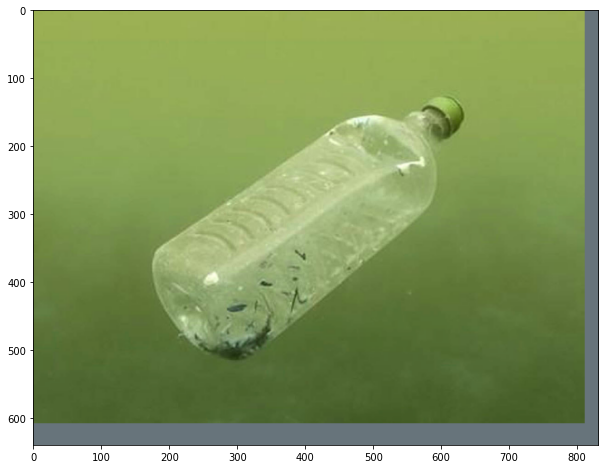

In [ ]:
show_pred_on_image('./ladakh-orders-ban-on-use-of-plastic-water-bottles-in-govt-offices-other-institutions.jpg', loaded_model, thres=0.3)

In [ ]:
!wget https://5.imimg.com/data5/QZ/UY/SL/SELLER-3541922/coke-can-500x500.jpg

--2021-06-22 06:56:10--  https://5.imimg.com/data5/QZ/UY/SL/SELLER-3541922/coke-can-500x500.jpg
Resolving 5.imimg.com (5.imimg.com)... 13.35.0.92, 13.35.0.78, 13.35.0.124, ...
Connecting to 5.imimg.com (5.imimg.com)|13.35.0.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34155 (33K) [image/jpeg]
Saving to: ‘coke-can-500x500.jpg’

coke-can-500x500.jp 100%[===================>]  33.35K  --.-KB/s    in 0.001s  

2021-06-22 06:56:11 (24.7 MB/s) - ‘coke-can-500x500.jpg’ saved [34155/34155]



torch.Size([1, 3, 640, 832])

 Total Time - 0.11344623565673828



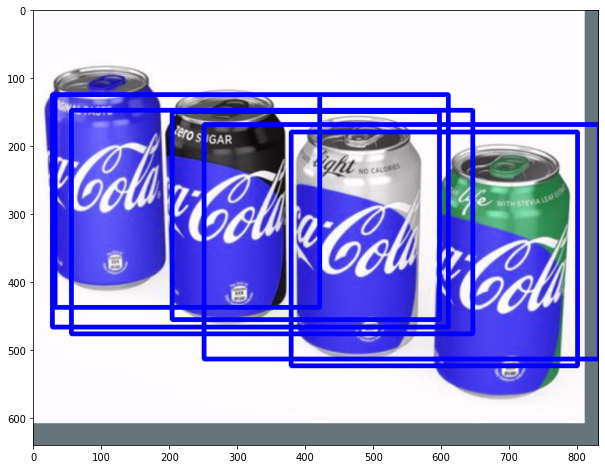

In [ ]:
# show_pred_on_image('./coke-can-500x500.jpg', retinanet, thres=0.2)
show_pred_on_image('./coke-can-500x500.jpg', loaded_model, thres=0.3)

In [ ]:
!wget https://static3.bigstockphoto.com/7/3/2/large1500/237369025.jpg

--2021-06-22 07:00:41--  https://static3.bigstockphoto.com/7/3/2/large1500/237369025.jpg
Resolving static3.bigstockphoto.com (static3.bigstockphoto.com)... 13.35.0.48, 13.35.0.82, 13.35.0.6, ...
Connecting to static3.bigstockphoto.com (static3.bigstockphoto.com)|13.35.0.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143098 (140K) [image/jpeg]
Saving to: ‘237369025.jpg’

237369025.jpg       100%[===================>] 139.74K   320KB/s    in 0.4s    

2021-06-22 07:00:42 (320 KB/s) - ‘237369025.jpg’ saved [143098/143098]



torch.Size([1, 3, 640, 832])

 Total Time - 0.10655331611633301



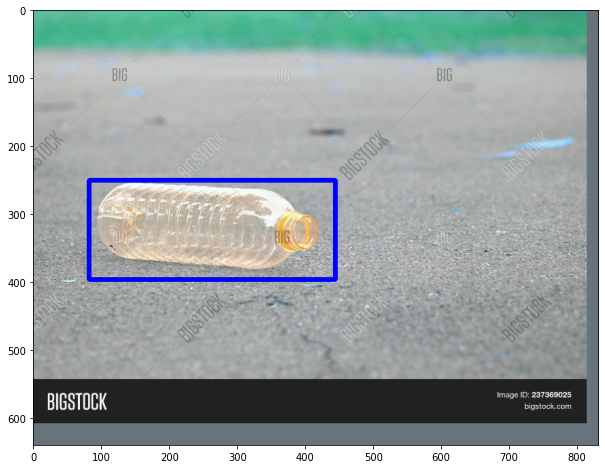

In [ ]:
show_pred_on_image('237369025.jpg', loaded_model, thres=0.3)